Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:12<00:00, 13115993.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


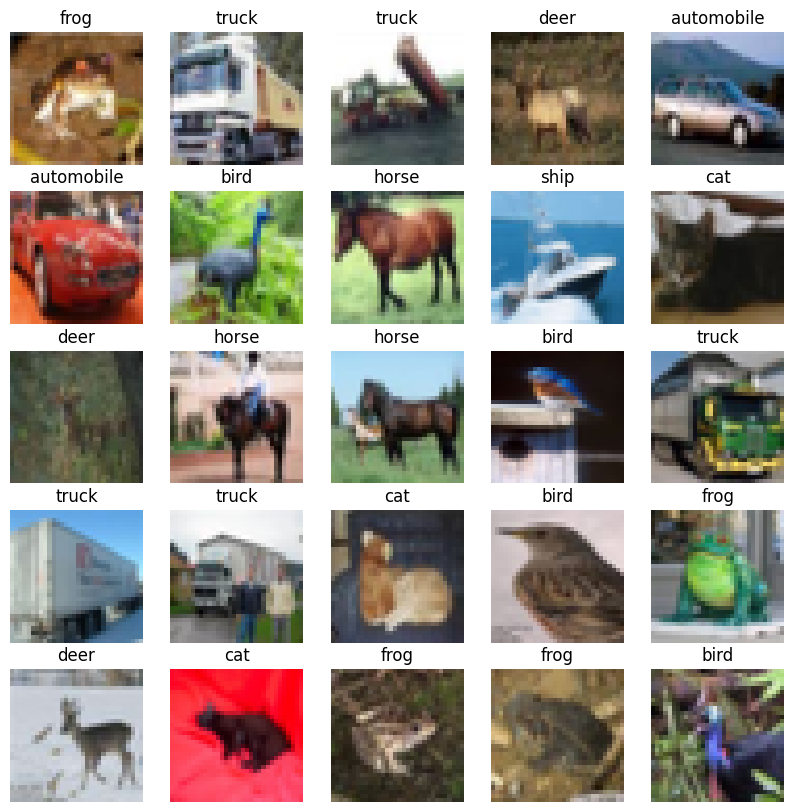

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)

  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.1
weightDecay = 0.0001

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:17<1:29:16, 17.91s/it]

Training Loss : 1.8039858946228027, Testing Loss : 1.6897439306259154, Training Accuracy : 0.34624, Testing Accuracy : 0.3976


  1%|          | 2/300 [00:28<1:08:04, 13.71s/it]

Training Loss : 1.4535272792053222, Testing Loss : 1.484065489578247, Training Accuracy : 0.47736, Testing Accuracy : 0.5071


  1%|          | 3/300 [00:39<1:00:44, 12.27s/it]

Training Loss : 1.2151774018859862, Testing Loss : 1.3223109014511107, Training Accuracy : 0.5695, Testing Accuracy : 0.5589


  1%|▏         | 4/300 [00:50<57:46, 11.71s/it]  

Training Loss : 1.0743162228393555, Testing Loss : 1.1097390653610228, Training Accuracy : 0.62058, Testing Accuracy : 0.6197


  2%|▏         | 5/300 [01:01<56:14, 11.44s/it]

Training Loss : 0.958942388305664, Testing Loss : 0.9684177831649781, Training Accuracy : 0.66412, Testing Accuracy : 0.6681


  2%|▏         | 6/300 [01:11<55:08, 11.25s/it]

Training Loss : 0.8769328985595704, Testing Loss : 0.9346914889335632, Training Accuracy : 0.6964, Testing Accuracy : 0.6823


  2%|▏         | 7/300 [01:22<53:53, 11.03s/it]

Training Loss : 0.8088454056549073, Testing Loss : 0.8861359592437744, Training Accuracy : 0.71858, Testing Accuracy : 0.7109


  3%|▎         | 8/300 [01:33<52:57, 10.88s/it]

Training Loss : 0.7516258584594726, Testing Loss : 0.8283341255187988, Training Accuracy : 0.7398, Testing Accuracy : 0.7176


  3%|▎         | 9/300 [01:43<52:01, 10.73s/it]

Training Loss : 0.7123086280822754, Testing Loss : 0.7878252492904663, Training Accuracy : 0.75484, Testing Accuracy : 0.7352


  3%|▎         | 10/300 [01:54<51:34, 10.67s/it]

Training Loss : 0.6665822357177734, Testing Loss : 0.7834860476493836, Training Accuracy : 0.7699, Testing Accuracy : 0.7355


  4%|▎         | 11/300 [02:04<51:11, 10.63s/it]

Training Loss : 0.6376723461914062, Testing Loss : 0.73821693649292, Training Accuracy : 0.78048, Testing Accuracy : 0.744


  4%|▍         | 12/300 [02:15<50:49, 10.59s/it]

Training Loss : 0.6054294813537597, Testing Loss : 0.6826201729774475, Training Accuracy : 0.79178, Testing Accuracy : 0.7725


  4%|▍         | 13/300 [02:25<50:20, 10.52s/it]

Training Loss : 0.5743071241760254, Testing Loss : 0.7281355260849, Training Accuracy : 0.80248, Testing Accuracy : 0.7617


  5%|▍         | 14/300 [02:35<50:07, 10.51s/it]

Training Loss : 0.5583894021606445, Testing Loss : 0.7052005967140198, Training Accuracy : 0.80688, Testing Accuracy : 0.7577


  5%|▌         | 15/300 [02:46<49:56, 10.51s/it]

Training Loss : 0.5286332513427734, Testing Loss : 0.6540711825370789, Training Accuracy : 0.81718, Testing Accuracy : 0.7842


  5%|▌         | 16/300 [02:56<49:46, 10.52s/it]

Training Loss : 0.49713446800231936, Testing Loss : 0.5932445583343506, Training Accuracy : 0.82886, Testing Accuracy : 0.7969


  6%|▌         | 17/300 [03:07<49:35, 10.51s/it]

Training Loss : 0.4686363035964966, Testing Loss : 0.5722500520706176, Training Accuracy : 0.83632, Testing Accuracy : 0.8044


  6%|▌         | 18/300 [03:17<49:24, 10.51s/it]

Training Loss : 0.4688814149475098, Testing Loss : 0.6505113147735596, Training Accuracy : 0.83944, Testing Accuracy : 0.786


  6%|▋         | 19/300 [03:28<48:56, 10.45s/it]

Training Loss : 0.4474466379165649, Testing Loss : 0.6218277051925659, Training Accuracy : 0.8457, Testing Accuracy : 0.7957


  7%|▋         | 20/300 [03:38<49:01, 10.51s/it]

Training Loss : 0.4187873313522339, Testing Loss : 0.5686006244659424, Training Accuracy : 0.85508, Testing Accuracy : 0.8062


  7%|▋         | 21/300 [03:49<49:01, 10.54s/it]

Training Loss : 0.42109360515594485, Testing Loss : 0.5825013703346252, Training Accuracy : 0.85486, Testing Accuracy : 0.8046


  7%|▋         | 22/300 [04:00<48:55, 10.56s/it]

Training Loss : 0.4048523459625244, Testing Loss : 0.5647607137203217, Training Accuracy : 0.85988, Testing Accuracy : 0.8108


  8%|▊         | 23/300 [04:10<48:21, 10.48s/it]

Training Loss : 0.4011773704528809, Testing Loss : 0.537052029132843, Training Accuracy : 0.86186, Testing Accuracy : 0.8192


  8%|▊         | 24/300 [04:21<48:25, 10.53s/it]

Training Loss : 0.3784559675598145, Testing Loss : 0.529848868560791, Training Accuracy : 0.86986, Testing Accuracy : 0.8239


  8%|▊         | 25/300 [04:31<48:04, 10.49s/it]

Training Loss : 0.36732225189208983, Testing Loss : 0.5585983163833618, Training Accuracy : 0.87332, Testing Accuracy : 0.8095


  9%|▊         | 26/300 [04:41<47:54, 10.49s/it]

Training Loss : 0.3625633681869507, Testing Loss : 0.5165279592037201, Training Accuracy : 0.87678, Testing Accuracy : 0.824


  9%|▉         | 27/300 [04:52<47:42, 10.48s/it]

Training Loss : 0.335613476600647, Testing Loss : 0.5165335755348206, Training Accuracy : 0.88544, Testing Accuracy : 0.8217


  9%|▉         | 28/300 [05:02<47:26, 10.47s/it]

Training Loss : 0.33209218811035157, Testing Loss : 0.5591623102664948, Training Accuracy : 0.88458, Testing Accuracy : 0.8158


 10%|▉         | 29/300 [05:13<47:23, 10.49s/it]

Training Loss : 0.3213372745513916, Testing Loss : 0.5500715371131897, Training Accuracy : 0.88876, Testing Accuracy : 0.819


 10%|█         | 30/300 [05:23<47:19, 10.52s/it]

Training Loss : 0.3119101872253418, Testing Loss : 0.5183124316215515, Training Accuracy : 0.89246, Testing Accuracy : 0.829


 10%|█         | 31/300 [05:34<47:07, 10.51s/it]

Training Loss : 0.3112464966583252, Testing Loss : 0.540193204498291, Training Accuracy : 0.89252, Testing Accuracy : 0.8268


 11%|█         | 32/300 [05:44<46:49, 10.48s/it]

Training Loss : 0.3081978011703491, Testing Loss : 0.5134799327850342, Training Accuracy : 0.89328, Testing Accuracy : 0.8294


 11%|█         | 33/300 [05:55<46:41, 10.49s/it]

Training Loss : 0.2968486685943604, Testing Loss : 0.5337840971946717, Training Accuracy : 0.89718, Testing Accuracy : 0.8293


 11%|█▏        | 34/300 [06:05<46:39, 10.52s/it]

Training Loss : 0.2918484392547607, Testing Loss : 0.5273434123992919, Training Accuracy : 0.89856, Testing Accuracy : 0.8309


 12%|█▏        | 35/300 [06:16<46:22, 10.50s/it]

Training Loss : 0.29627915853500364, Testing Loss : 0.5643204403400421, Training Accuracy : 0.8964, Testing Accuracy : 0.8226


 12%|█▏        | 36/300 [06:26<46:14, 10.51s/it]

Training Loss : 0.2791179765510559, Testing Loss : 0.5018924753189087, Training Accuracy : 0.90358, Testing Accuracy : 0.8425


 12%|█▏        | 37/300 [06:37<46:10, 10.53s/it]

Training Loss : 0.2555919818687439, Testing Loss : 0.5054207555294037, Training Accuracy : 0.91072, Testing Accuracy : 0.843


 13%|█▎        | 38/300 [06:48<45:58, 10.53s/it]

Training Loss : 0.2484062228012085, Testing Loss : 0.4769809401512146, Training Accuracy : 0.91464, Testing Accuracy : 0.8473


 13%|█▎        | 39/300 [06:58<45:45, 10.52s/it]

Training Loss : 0.2478554128074646, Testing Loss : 0.5350058387756348, Training Accuracy : 0.9139, Testing Accuracy : 0.8379


 13%|█▎        | 40/300 [07:09<45:32, 10.51s/it]

Training Loss : 0.24618750719070434, Testing Loss : 0.4948822336196899, Training Accuracy : 0.91432, Testing Accuracy : 0.85


 14%|█▎        | 41/300 [07:19<45:21, 10.51s/it]

Training Loss : 0.2255802089881897, Testing Loss : 0.5136982271671295, Training Accuracy : 0.92132, Testing Accuracy : 0.8451


 14%|█▍        | 42/300 [07:30<45:11, 10.51s/it]

Training Loss : 0.2341097627067566, Testing Loss : 0.5105106997489929, Training Accuracy : 0.91906, Testing Accuracy : 0.8457


 14%|█▍        | 43/300 [07:40<44:45, 10.45s/it]

Training Loss : 0.2183637377357483, Testing Loss : 0.5047359149932862, Training Accuracy : 0.92354, Testing Accuracy : 0.8471


 15%|█▍        | 44/300 [07:51<44:47, 10.50s/it]

Training Loss : 0.2121827426338196, Testing Loss : 0.4832543954849243, Training Accuracy : 0.92544, Testing Accuracy : 0.8581


 15%|█▌        | 45/300 [08:01<44:28, 10.47s/it]

Training Loss : 0.20674517749786378, Testing Loss : 0.5206252309799194, Training Accuracy : 0.92852, Testing Accuracy : 0.844


 15%|█▌        | 46/300 [08:11<44:13, 10.45s/it]

Training Loss : 0.20512979910850526, Testing Loss : 0.49612180156707764, Training Accuracy : 0.92874, Testing Accuracy : 0.8572


 16%|█▌        | 47/300 [08:22<44:06, 10.46s/it]

Training Loss : 0.1916883228302002, Testing Loss : 0.4924362487316132, Training Accuracy : 0.93396, Testing Accuracy : 0.8603


 16%|█▌        | 48/300 [08:32<43:51, 10.44s/it]

Training Loss : 0.19237423384666444, Testing Loss : 0.4716417234420776, Training Accuracy : 0.93316, Testing Accuracy : 0.8604


 16%|█▋        | 49/300 [08:43<43:43, 10.45s/it]

Training Loss : 0.19094739442825318, Testing Loss : 0.5207781277656555, Training Accuracy : 0.93292, Testing Accuracy : 0.8512


 17%|█▋        | 50/300 [08:53<43:38, 10.47s/it]

Training Loss : 0.1863956339263916, Testing Loss : 0.49055629148483276, Training Accuracy : 0.93654, Testing Accuracy : 0.8535


 17%|█▋        | 51/300 [09:04<43:31, 10.49s/it]

Training Loss : 0.1770270148086548, Testing Loss : 0.49403465080261233, Training Accuracy : 0.93784, Testing Accuracy : 0.8627


 17%|█▋        | 52/300 [09:14<43:23, 10.50s/it]

Training Loss : 0.1790834361076355, Testing Loss : 0.5689274739265442, Training Accuracy : 0.937, Testing Accuracy : 0.8472


 18%|█▊        | 53/300 [09:25<43:03, 10.46s/it]

Training Loss : 0.18385590421676637, Testing Loss : 0.5040769903659821, Training Accuracy : 0.93584, Testing Accuracy : 0.858


 18%|█▊        | 54/300 [09:35<42:53, 10.46s/it]

Training Loss : 0.17448520579338073, Testing Loss : 0.5324612390518189, Training Accuracy : 0.93866, Testing Accuracy : 0.8522


 18%|█▊        | 55/300 [09:46<42:47, 10.48s/it]

Training Loss : 0.16902895782470703, Testing Loss : 0.49925940709114075, Training Accuracy : 0.94112, Testing Accuracy : 0.8599


 19%|█▊        | 56/300 [09:56<42:35, 10.47s/it]

Training Loss : 0.14991054982185364, Testing Loss : 0.5088869064331055, Training Accuracy : 0.9474, Testing Accuracy : 0.8658


 19%|█▉        | 57/300 [10:06<42:24, 10.47s/it]

Training Loss : 0.15758106722831727, Testing Loss : 0.5259425702095032, Training Accuracy : 0.94532, Testing Accuracy : 0.8555


 19%|█▉        | 58/300 [10:17<42:10, 10.46s/it]

Training Loss : 0.17330091126441954, Testing Loss : 0.511329147529602, Training Accuracy : 0.93978, Testing Accuracy : 0.8585


 20%|█▉        | 59/300 [10:27<41:58, 10.45s/it]

Training Loss : 0.15837101454734803, Testing Loss : 0.5045986362457275, Training Accuracy : 0.94464, Testing Accuracy : 0.8648


 20%|██        | 60/300 [10:38<41:40, 10.42s/it]

Training Loss : 0.15932213017463684, Testing Loss : 0.5806822866439819, Training Accuracy : 0.94384, Testing Accuracy : 0.8498


 20%|██        | 61/300 [10:48<41:30, 10.42s/it]

Training Loss : 0.15814454458236693, Testing Loss : 0.5225679076194764, Training Accuracy : 0.94476, Testing Accuracy : 0.8637


 21%|██        | 62/300 [10:59<41:20, 10.42s/it]

Training Loss : 0.13854710619449614, Testing Loss : 0.49680279369354247, Training Accuracy : 0.9522, Testing Accuracy : 0.8681


 21%|██        | 63/300 [11:09<41:15, 10.44s/it]

Training Loss : 0.12630545228004456, Testing Loss : 0.5858434223175049, Training Accuracy : 0.95616, Testing Accuracy : 0.8666


 21%|██▏       | 64/300 [11:20<41:13, 10.48s/it]

Training Loss : 0.13901235408782958, Testing Loss : 0.5511390904426575, Training Accuracy : 0.95184, Testing Accuracy : 0.8576


 22%|██▏       | 65/300 [11:30<41:03, 10.48s/it]

Training Loss : 0.14222996784687042, Testing Loss : 0.5418841464996338, Training Accuracy : 0.9519, Testing Accuracy : 0.8624


 22%|██▏       | 66/300 [11:41<40:59, 10.51s/it]

Training Loss : 0.1406521982574463, Testing Loss : 0.5011373914718628, Training Accuracy : 0.95094, Testing Accuracy : 0.8691


 22%|██▏       | 67/300 [11:51<40:54, 10.53s/it]

Training Loss : 0.12172062935829163, Testing Loss : 0.5595217540740967, Training Accuracy : 0.95794, Testing Accuracy : 0.8722


 23%|██▎       | 68/300 [12:02<40:34, 10.49s/it]

Training Loss : 0.11791456081390381, Testing Loss : 0.5593777235031128, Training Accuracy : 0.95802, Testing Accuracy : 0.8615


 23%|██▎       | 69/300 [12:12<40:33, 10.54s/it]

Training Loss : 0.12313573212623596, Testing Loss : 0.5866769834518433, Training Accuracy : 0.95712, Testing Accuracy : 0.8625


 23%|██▎       | 70/300 [12:23<40:23, 10.54s/it]

Training Loss : 0.12145038003921509, Testing Loss : 0.5584493242263794, Training Accuracy : 0.95784, Testing Accuracy : 0.8668


 24%|██▎       | 71/300 [12:33<40:08, 10.52s/it]

Training Loss : 0.12153223126411437, Testing Loss : 0.5548799276351929, Training Accuracy : 0.9569, Testing Accuracy : 0.87


 24%|██▍       | 72/300 [12:44<39:51, 10.49s/it]

Training Loss : 0.11124391367912292, Testing Loss : 0.5431348188877105, Training Accuracy : 0.96154, Testing Accuracy : 0.8728


 24%|██▍       | 73/300 [12:54<39:38, 10.48s/it]

Training Loss : 0.11321613660812378, Testing Loss : 0.5487864411354065, Training Accuracy : 0.96052, Testing Accuracy : 0.8658


 25%|██▍       | 74/300 [13:05<39:25, 10.47s/it]

Training Loss : 0.10992937152862549, Testing Loss : 0.5636327493667602, Training Accuracy : 0.96112, Testing Accuracy : 0.8674


 25%|██▌       | 75/300 [13:15<39:19, 10.49s/it]

Training Loss : 0.121138352394104, Testing Loss : 0.5546790708065032, Training Accuracy : 0.9589, Testing Accuracy : 0.8618


 25%|██▌       | 76/300 [13:26<39:16, 10.52s/it]

Training Loss : 0.1103056987285614, Testing Loss : 0.5571788661956787, Training Accuracy : 0.96142, Testing Accuracy : 0.8718


 26%|██▌       | 77/300 [13:36<39:01, 10.50s/it]

Training Loss : 0.10982184557199479, Testing Loss : 0.5624813726425171, Training Accuracy : 0.96224, Testing Accuracy : 0.8643


 26%|██▌       | 78/300 [13:47<38:38, 10.44s/it]

Training Loss : 0.11291264252662658, Testing Loss : 0.5595598352432251, Training Accuracy : 0.9606, Testing Accuracy : 0.8683


 26%|██▋       | 79/300 [13:57<38:42, 10.51s/it]

Training Loss : 0.09553806198120117, Testing Loss : 0.5802261679172516, Training Accuracy : 0.96674, Testing Accuracy : 0.8771


 27%|██▋       | 80/300 [14:08<38:29, 10.50s/it]

Training Loss : 0.10497813343763351, Testing Loss : 0.5638610741615295, Training Accuracy : 0.96336, Testing Accuracy : 0.8719


 27%|██▋       | 81/300 [14:18<38:17, 10.49s/it]

Training Loss : 0.10947185671329498, Testing Loss : 0.5553771025657653, Training Accuracy : 0.9627, Testing Accuracy : 0.8736


 27%|██▋       | 82/300 [14:29<38:11, 10.51s/it]

Training Loss : 0.10208023230314255, Testing Loss : 0.5627684059143067, Training Accuracy : 0.9642, Testing Accuracy : 0.8684


 28%|██▊       | 83/300 [14:39<38:06, 10.54s/it]

Training Loss : 0.09875819722652435, Testing Loss : 0.5794248271226883, Training Accuracy : 0.96632, Testing Accuracy : 0.8702


 28%|██▊       | 84/300 [14:50<38:08, 10.59s/it]

Training Loss : 0.09430543474197388, Testing Loss : 0.5570873516082764, Training Accuracy : 0.96788, Testing Accuracy : 0.8719


 28%|██▊       | 85/300 [15:01<38:23, 10.71s/it]

Training Loss : 0.08950754607200623, Testing Loss : 0.5898326288223267, Training Accuracy : 0.9691, Testing Accuracy : 0.8675


 29%|██▊       | 86/300 [15:12<38:24, 10.77s/it]

Training Loss : 0.09752204181909561, Testing Loss : 0.5879036172866822, Training Accuracy : 0.96546, Testing Accuracy : 0.872


 29%|██▉       | 87/300 [15:22<38:00, 10.71s/it]

Training Loss : 0.08914138135433197, Testing Loss : 0.5747225543022155, Training Accuracy : 0.9698, Testing Accuracy : 0.8714


 29%|██▉       | 88/300 [15:33<37:36, 10.64s/it]

Training Loss : 0.0888792085313797, Testing Loss : 0.5662716192245484, Training Accuracy : 0.96866, Testing Accuracy : 0.8744


 30%|██▉       | 89/300 [15:44<37:20, 10.62s/it]

Training Loss : 0.0858619394826889, Testing Loss : 0.5736703376770019, Training Accuracy : 0.97038, Testing Accuracy : 0.8749


 30%|███       | 90/300 [15:54<36:58, 10.57s/it]

Training Loss : 0.08508045455694199, Testing Loss : 0.5561772408485413, Training Accuracy : 0.97046, Testing Accuracy : 0.8731


 30%|███       | 91/300 [16:05<36:48, 10.57s/it]

Training Loss : 0.08956125494003296, Testing Loss : 0.6519234956264496, Training Accuracy : 0.97002, Testing Accuracy : 0.8691


 31%|███       | 92/300 [16:15<36:36, 10.56s/it]

Training Loss : 0.09237123931646347, Testing Loss : 0.538590881061554, Training Accuracy : 0.968, Testing Accuracy : 0.8734


 31%|███       | 93/300 [16:26<36:27, 10.57s/it]

Training Loss : 0.08513912925004959, Testing Loss : 0.6077680300712586, Training Accuracy : 0.97036, Testing Accuracy : 0.8759


 31%|███▏      | 94/300 [16:36<36:21, 10.59s/it]

Training Loss : 0.08106371237516403, Testing Loss : 0.510770179271698, Training Accuracy : 0.97272, Testing Accuracy : 0.8794


 32%|███▏      | 95/300 [16:47<35:58, 10.53s/it]

Training Loss : 0.07308760681033134, Testing Loss : 0.6564773477554321, Training Accuracy : 0.97502, Testing Accuracy : 0.8774


 32%|███▏      | 96/300 [16:57<35:46, 10.52s/it]

Training Loss : 0.076367457767725, Testing Loss : 0.5791396293640136, Training Accuracy : 0.97344, Testing Accuracy : 0.8699


 32%|███▏      | 97/300 [17:08<35:34, 10.51s/it]

Training Loss : 0.08472693059206009, Testing Loss : 0.5604875749111176, Training Accuracy : 0.97074, Testing Accuracy : 0.8777


 33%|███▎      | 98/300 [17:18<35:22, 10.51s/it]

Training Loss : 0.07324089839994907, Testing Loss : 0.580528271484375, Training Accuracy : 0.9753, Testing Accuracy : 0.8734


 33%|███▎      | 99/300 [17:29<35:16, 10.53s/it]

Training Loss : 0.06539321751713753, Testing Loss : 0.6830694160461426, Training Accuracy : 0.97738, Testing Accuracy : 0.8768


 33%|███▎      | 100/300 [17:39<35:07, 10.54s/it]

Training Loss : 0.07512799761295319, Testing Loss : 0.5951248880863189, Training Accuracy : 0.97398, Testing Accuracy : 0.8708


 34%|███▎      | 101/300 [17:50<35:03, 10.57s/it]

Training Loss : 0.07740908733248711, Testing Loss : 0.6581878997325897, Training Accuracy : 0.9748, Testing Accuracy : 0.8804


 34%|███▍      | 102/300 [18:00<34:48, 10.55s/it]

Training Loss : 0.0713446849656105, Testing Loss : 0.5950521847724914, Training Accuracy : 0.97508, Testing Accuracy : 0.8764


 34%|███▍      | 103/300 [18:11<34:36, 10.54s/it]

Training Loss : 0.07028611120343209, Testing Loss : 0.6464896026134491, Training Accuracy : 0.976, Testing Accuracy : 0.8748


 35%|███▍      | 104/300 [18:22<34:25, 10.54s/it]

Training Loss : 0.07870630956292153, Testing Loss : 0.644179892539978, Training Accuracy : 0.97234, Testing Accuracy : 0.8682


 35%|███▌      | 105/300 [18:32<34:19, 10.56s/it]

Training Loss : 0.07438281845331192, Testing Loss : 0.6321280162811279, Training Accuracy : 0.97476, Testing Accuracy : 0.8761


 35%|███▌      | 106/300 [18:43<34:09, 10.56s/it]

Training Loss : 0.06832578433036804, Testing Loss : 0.5941459451675415, Training Accuracy : 0.97666, Testing Accuracy : 0.8748


 36%|███▌      | 107/300 [18:53<33:58, 10.56s/it]

Training Loss : 0.07085503927230835, Testing Loss : 0.5917202163696289, Training Accuracy : 0.9758, Testing Accuracy : 0.8791


 36%|███▌      | 108/300 [19:04<33:48, 10.57s/it]

Training Loss : 0.059565697174072264, Testing Loss : 0.6070867580413818, Training Accuracy : 0.97958, Testing Accuracy : 0.8828


 36%|███▋      | 109/300 [19:14<33:41, 10.59s/it]

Training Loss : 0.061882934695482256, Testing Loss : 0.589839541053772, Training Accuracy : 0.97922, Testing Accuracy : 0.8815


 37%|███▋      | 110/300 [19:25<33:38, 10.62s/it]

Training Loss : 0.05332510359346867, Testing Loss : 0.6315917677856981, Training Accuracy : 0.98126, Testing Accuracy : 0.8864


 37%|███▋      | 111/300 [19:36<33:27, 10.62s/it]

Training Loss : 0.05746205803871155, Testing Loss : 0.5816237141609192, Training Accuracy : 0.97908, Testing Accuracy : 0.8878


 37%|███▋      | 112/300 [19:46<33:19, 10.63s/it]

Training Loss : 0.05591440409779549, Testing Loss : 0.6385410516262054, Training Accuracy : 0.98028, Testing Accuracy : 0.8789


 38%|███▊      | 113/300 [19:57<33:06, 10.62s/it]

Training Loss : 0.05960556414663792, Testing Loss : 0.6403827764511109, Training Accuracy : 0.97988, Testing Accuracy : 0.8764


 38%|███▊      | 114/300 [20:08<32:59, 10.64s/it]

Training Loss : 0.06737063118577004, Testing Loss : 0.6816926697731018, Training Accuracy : 0.97882, Testing Accuracy : 0.879


 38%|███▊      | 115/300 [20:18<32:40, 10.60s/it]

Training Loss : 0.06526972822189331, Testing Loss : 0.5836259759023785, Training Accuracy : 0.9779, Testing Accuracy : 0.8795


 39%|███▊      | 116/300 [20:29<32:20, 10.55s/it]

Training Loss : 0.049900642389655116, Testing Loss : 0.6601491583824157, Training Accuracy : 0.98318, Testing Accuracy : 0.8814


 39%|███▉      | 117/300 [20:39<32:03, 10.51s/it]

Training Loss : 0.0510327409785986, Testing Loss : 0.6052101873040199, Training Accuracy : 0.9828, Testing Accuracy : 0.8829


 39%|███▉      | 118/300 [20:50<31:52, 10.51s/it]

Training Loss : 0.052599145773649214, Testing Loss : 0.6983327453613282, Training Accuracy : 0.98194, Testing Accuracy : 0.8801


 40%|███▉      | 119/300 [21:00<31:41, 10.50s/it]

Training Loss : 0.05793479568004608, Testing Loss : 0.620301678276062, Training Accuracy : 0.98008, Testing Accuracy : 0.8778


 40%|████      | 120/300 [21:11<31:35, 10.53s/it]

Training Loss : 0.05619568955779076, Testing Loss : 0.6764983579635621, Training Accuracy : 0.98116, Testing Accuracy : 0.8797


 40%|████      | 121/300 [21:21<31:22, 10.52s/it]

Training Loss : 0.05396312261402607, Testing Loss : 0.6325341170787812, Training Accuracy : 0.98086, Testing Accuracy : 0.8814


 41%|████      | 122/300 [21:32<31:12, 10.52s/it]

Training Loss : 0.05964571954965591, Testing Loss : 0.6645005163192749, Training Accuracy : 0.9805, Testing Accuracy : 0.8811


 41%|████      | 123/300 [21:42<31:00, 10.51s/it]

Training Loss : 0.0589993361222744, Testing Loss : 0.574197193813324, Training Accuracy : 0.98044, Testing Accuracy : 0.8856


 41%|████▏     | 124/300 [21:53<30:53, 10.53s/it]

Training Loss : 0.04736375063627958, Testing Loss : 0.6815359782814979, Training Accuracy : 0.9844, Testing Accuracy : 0.8776


 42%|████▏     | 125/300 [22:03<30:36, 10.50s/it]

Training Loss : 0.05080543309301138, Testing Loss : 0.6518617847442627, Training Accuracy : 0.98346, Testing Accuracy : 0.8819


 42%|████▏     | 126/300 [22:14<30:24, 10.49s/it]

Training Loss : 0.048880952573418616, Testing Loss : 0.6864439427852631, Training Accuracy : 0.9833, Testing Accuracy : 0.8826


 42%|████▏     | 127/300 [22:24<30:13, 10.48s/it]

Training Loss : 0.04106517664015293, Testing Loss : 0.631265403175354, Training Accuracy : 0.98656, Testing Accuracy : 0.886


 43%|████▎     | 128/300 [22:35<30:08, 10.52s/it]

Training Loss : 0.04382838157713413, Testing Loss : 0.6067347257137299, Training Accuracy : 0.98494, Testing Accuracy : 0.8892


 43%|████▎     | 129/300 [22:45<30:04, 10.55s/it]

Training Loss : 0.04422769280433655, Testing Loss : 0.6708236993789672, Training Accuracy : 0.98484, Testing Accuracy : 0.8861


 43%|████▎     | 130/300 [22:56<29:57, 10.57s/it]

Training Loss : 0.05005574136972427, Testing Loss : 0.6390947978496552, Training Accuracy : 0.98294, Testing Accuracy : 0.8823


 44%|████▎     | 131/300 [23:06<29:42, 10.55s/it]

Training Loss : 0.048752864904999735, Testing Loss : 0.647335523891449, Training Accuracy : 0.98388, Testing Accuracy : 0.8813


 44%|████▍     | 132/300 [23:17<29:26, 10.51s/it]

Training Loss : 0.04895555090010166, Testing Loss : 0.6895544940948486, Training Accuracy : 0.9834, Testing Accuracy : 0.8787


 44%|████▍     | 133/300 [23:27<29:19, 10.54s/it]

Training Loss : 0.04565281794890761, Testing Loss : 0.6336776279449463, Training Accuracy : 0.98424, Testing Accuracy : 0.8836


 45%|████▍     | 134/300 [23:38<29:09, 10.54s/it]

Training Loss : 0.04385908423244953, Testing Loss : 0.6413567535400391, Training Accuracy : 0.98516, Testing Accuracy : 0.885


 45%|████▌     | 135/300 [23:49<29:03, 10.56s/it]

Training Loss : 0.042167588477134706, Testing Loss : 0.6492469086647034, Training Accuracy : 0.9857, Testing Accuracy : 0.8853


 45%|████▌     | 136/300 [23:59<28:52, 10.57s/it]

Training Loss : 0.03743272882372141, Testing Loss : 0.7013803705215454, Training Accuracy : 0.98694, Testing Accuracy : 0.8867


 46%|████▌     | 137/300 [24:10<28:41, 10.56s/it]

Training Loss : 0.03947250443518162, Testing Loss : 0.6565980848312378, Training Accuracy : 0.9868, Testing Accuracy : 0.8874


 46%|████▌     | 138/300 [24:20<28:30, 10.56s/it]

Training Loss : 0.037603191737234594, Testing Loss : 0.6842682859420777, Training Accuracy : 0.98722, Testing Accuracy : 0.8838


 46%|████▋     | 139/300 [24:31<28:19, 10.55s/it]

Training Loss : 0.04279793522179127, Testing Loss : 0.6283573885917664, Training Accuracy : 0.98582, Testing Accuracy : 0.886


 47%|████▋     | 140/300 [24:42<28:13, 10.58s/it]

Training Loss : 0.04250208570569754, Testing Loss : 0.7781096351623535, Training Accuracy : 0.985, Testing Accuracy : 0.8781


 47%|████▋     | 141/300 [24:52<28:00, 10.57s/it]

Training Loss : 0.04751065223455429, Testing Loss : 0.5681294118881226, Training Accuracy : 0.98408, Testing Accuracy : 0.8929


 47%|████▋     | 142/300 [25:03<27:50, 10.58s/it]

Training Loss : 0.033399332897663114, Testing Loss : 0.7113361916542054, Training Accuracy : 0.98826, Testing Accuracy : 0.8917


 48%|████▊     | 143/300 [25:13<27:39, 10.57s/it]

Training Loss : 0.029112808452062308, Testing Loss : 0.6472393607139587, Training Accuracy : 0.99046, Testing Accuracy : 0.8898


 48%|████▊     | 144/300 [25:24<27:34, 10.61s/it]

Training Loss : 0.03318127036273479, Testing Loss : 0.6781928763389588, Training Accuracy : 0.98894, Testing Accuracy : 0.8886


 48%|████▊     | 145/300 [25:34<27:16, 10.56s/it]

Training Loss : 0.03201228803612292, Testing Loss : 0.6413504110097885, Training Accuracy : 0.9893, Testing Accuracy : 0.893


 49%|████▊     | 146/300 [25:45<26:58, 10.51s/it]

Training Loss : 0.031182694883346556, Testing Loss : 0.7038993129730224, Training Accuracy : 0.98948, Testing Accuracy : 0.8868


 49%|████▉     | 147/300 [25:55<26:50, 10.53s/it]

Training Loss : 0.03385986906990409, Testing Loss : 0.6710026757240295, Training Accuracy : 0.9886, Testing Accuracy : 0.8851


 49%|████▉     | 148/300 [26:06<26:39, 10.52s/it]

Training Loss : 0.032783442948833105, Testing Loss : 0.657101391017437, Training Accuracy : 0.9893, Testing Accuracy : 0.8914


 50%|████▉     | 149/300 [26:17<26:39, 10.59s/it]

Training Loss : 0.027127640295103193, Testing Loss : 0.6812200413227081, Training Accuracy : 0.99054, Testing Accuracy : 0.8954


 50%|█████     | 150/300 [26:27<26:31, 10.61s/it]

Training Loss : 0.025690329601168634, Testing Loss : 0.6643095594406128, Training Accuracy : 0.99128, Testing Accuracy : 0.8927


 50%|█████     | 151/300 [26:38<26:21, 10.61s/it]

Training Loss : 0.02993214506044984, Testing Loss : 0.7114285902023315, Training Accuracy : 0.98996, Testing Accuracy : 0.8904


 51%|█████     | 152/300 [26:48<26:10, 10.61s/it]

Training Loss : 0.029846401427984236, Testing Loss : 0.6621591809272767, Training Accuracy : 0.99008, Testing Accuracy : 0.8892


 51%|█████     | 153/300 [26:59<25:58, 10.61s/it]

Training Loss : 0.03101967077165842, Testing Loss : 0.6738287343978882, Training Accuracy : 0.99, Testing Accuracy : 0.8916


 51%|█████▏    | 154/300 [27:10<25:44, 10.58s/it]

Training Loss : 0.02738462324410677, Testing Loss : 0.6793559789657593, Training Accuracy : 0.99084, Testing Accuracy : 0.8929


 52%|█████▏    | 155/300 [27:20<25:26, 10.53s/it]

Training Loss : 0.02562477448821068, Testing Loss : 0.6940288080215454, Training Accuracy : 0.99088, Testing Accuracy : 0.8922


 52%|█████▏    | 156/300 [27:31<25:20, 10.56s/it]

Training Loss : 0.025833069552332163, Testing Loss : 0.7084872383117676, Training Accuracy : 0.99164, Testing Accuracy : 0.8887


 52%|█████▏    | 157/300 [27:41<25:12, 10.58s/it]

Training Loss : 0.029629825223758816, Testing Loss : 0.6762487905502319, Training Accuracy : 0.98952, Testing Accuracy : 0.8972


 53%|█████▎    | 158/300 [27:52<25:04, 10.60s/it]

Training Loss : 0.029348809131905438, Testing Loss : 0.6611638592720032, Training Accuracy : 0.9906, Testing Accuracy : 0.8907


 53%|█████▎    | 159/300 [28:02<24:54, 10.60s/it]

Training Loss : 0.022636927193403242, Testing Loss : 0.6853645848274231, Training Accuracy : 0.99248, Testing Accuracy : 0.9032


 53%|█████▎    | 160/300 [28:13<24:46, 10.62s/it]

Training Loss : 0.021205829245857895, Testing Loss : 0.6909103483200073, Training Accuracy : 0.99266, Testing Accuracy : 0.8947


 54%|█████▎    | 161/300 [28:24<24:36, 10.62s/it]

Training Loss : 0.021146290827691556, Testing Loss : 0.7065603846549988, Training Accuracy : 0.99234, Testing Accuracy : 0.8965


 54%|█████▍    | 162/300 [28:34<24:22, 10.60s/it]

Training Loss : 0.028352104462534188, Testing Loss : 0.7431992029190063, Training Accuracy : 0.99104, Testing Accuracy : 0.8886


 54%|█████▍    | 163/300 [28:45<24:09, 10.58s/it]

Training Loss : 0.02669409403130412, Testing Loss : 0.7015794219017029, Training Accuracy : 0.99112, Testing Accuracy : 0.8947


 55%|█████▍    | 164/300 [28:55<23:55, 10.55s/it]

Training Loss : 0.023645176611989737, Testing Loss : 0.6924249411582947, Training Accuracy : 0.99238, Testing Accuracy : 0.8921


 55%|█████▌    | 165/300 [29:06<23:45, 10.56s/it]

Training Loss : 0.021044970698431135, Testing Loss : 0.6897570167064667, Training Accuracy : 0.99264, Testing Accuracy : 0.8933


 55%|█████▌    | 166/300 [29:16<23:33, 10.55s/it]

Training Loss : 0.02231043200790882, Testing Loss : 0.7028934119224548, Training Accuracy : 0.99242, Testing Accuracy : 0.892


 56%|█████▌    | 167/300 [29:27<23:26, 10.58s/it]

Training Loss : 0.022267053091526032, Testing Loss : 0.7345810419559479, Training Accuracy : 0.99266, Testing Accuracy : 0.8938


 56%|█████▌    | 168/300 [29:38<23:19, 10.60s/it]

Training Loss : 0.023609687457606197, Testing Loss : 0.7202870671749115, Training Accuracy : 0.9924, Testing Accuracy : 0.8904


 56%|█████▋    | 169/300 [29:48<23:03, 10.56s/it]

Training Loss : 0.026139469594880938, Testing Loss : 0.7229505675315857, Training Accuracy : 0.99122, Testing Accuracy : 0.8905


 57%|█████▋    | 170/300 [29:59<22:50, 10.55s/it]

Training Loss : 0.024445866244994105, Testing Loss : 0.6905000761985779, Training Accuracy : 0.99212, Testing Accuracy : 0.8911


 57%|█████▋    | 171/300 [30:09<22:38, 10.53s/it]

Training Loss : 0.024865391392409803, Testing Loss : 0.7079733005523682, Training Accuracy : 0.99102, Testing Accuracy : 0.8894


 57%|█████▋    | 172/300 [30:20<22:31, 10.56s/it]

Training Loss : 0.023136966196857393, Testing Loss : 0.6880560932159424, Training Accuracy : 0.99204, Testing Accuracy : 0.8948


 58%|█████▊    | 173/300 [30:30<22:20, 10.55s/it]

Training Loss : 0.018356577902948482, Testing Loss : 0.6860624705314636, Training Accuracy : 0.99392, Testing Accuracy : 0.8979


 58%|█████▊    | 174/300 [30:41<22:11, 10.57s/it]

Training Loss : 0.01821591117143631, Testing Loss : 0.6994689878940582, Training Accuracy : 0.99354, Testing Accuracy : 0.8948


 58%|█████▊    | 175/300 [30:52<22:04, 10.60s/it]

Training Loss : 0.02116217580355704, Testing Loss : 0.7045968416213989, Training Accuracy : 0.99234, Testing Accuracy : 0.8908


 59%|█████▊    | 176/300 [31:02<21:53, 10.59s/it]

Training Loss : 0.019917335726097225, Testing Loss : 0.6954700038909912, Training Accuracy : 0.99344, Testing Accuracy : 0.8973


 59%|█████▉    | 177/300 [31:13<21:52, 10.67s/it]

Training Loss : 0.017671309938635676, Testing Loss : 0.735664843082428, Training Accuracy : 0.99406, Testing Accuracy : 0.8912


 59%|█████▉    | 178/300 [31:24<21:41, 10.67s/it]

Training Loss : 0.01740923254566267, Testing Loss : 0.7210032560825348, Training Accuracy : 0.99402, Testing Accuracy : 0.8981


 60%|█████▉    | 179/300 [31:35<21:43, 10.77s/it]

Training Loss : 0.01863672833742574, Testing Loss : 0.7541829319000244, Training Accuracy : 0.99374, Testing Accuracy : 0.8912


 60%|██████    | 180/300 [31:46<21:38, 10.82s/it]

Training Loss : 0.02025763812866062, Testing Loss : 0.7459327081203461, Training Accuracy : 0.9933, Testing Accuracy : 0.8959


 60%|██████    | 181/300 [31:57<21:39, 10.92s/it]

Training Loss : 0.0166540143699944, Testing Loss : 0.7489320663452148, Training Accuracy : 0.99438, Testing Accuracy : 0.8965


 61%|██████    | 182/300 [32:07<21:13, 10.79s/it]

Training Loss : 0.01708838842406869, Testing Loss : 0.7686076583862305, Training Accuracy : 0.9944, Testing Accuracy : 0.8971


 61%|██████    | 183/300 [32:18<20:54, 10.72s/it]

Training Loss : 0.01434600258548744, Testing Loss : 0.7476539753913879, Training Accuracy : 0.9951, Testing Accuracy : 0.898


 61%|██████▏   | 184/300 [32:28<20:34, 10.64s/it]

Training Loss : 0.012868660594262183, Testing Loss : 0.7546960234642028, Training Accuracy : 0.99574, Testing Accuracy : 0.8979


 62%|██████▏   | 185/300 [32:39<20:24, 10.65s/it]

Training Loss : 0.016187336071953176, Testing Loss : 0.7221391406059265, Training Accuracy : 0.9949, Testing Accuracy : 0.8973


 62%|██████▏   | 186/300 [32:49<20:08, 10.60s/it]

Training Loss : 0.01596190328616649, Testing Loss : 0.7579723783493042, Training Accuracy : 0.99438, Testing Accuracy : 0.8988


 62%|██████▏   | 187/300 [33:00<19:55, 10.58s/it]

Training Loss : 0.01305043810363859, Testing Loss : 0.7718986414909362, Training Accuracy : 0.9958, Testing Accuracy : 0.8977


 63%|██████▎   | 188/300 [33:10<19:41, 10.55s/it]

Training Loss : 0.023226304432246835, Testing Loss : 0.8554074896812439, Training Accuracy : 0.99256, Testing Accuracy : 0.8844


 63%|██████▎   | 189/300 [33:21<19:30, 10.55s/it]

Training Loss : 0.024819612183086575, Testing Loss : 0.7762033041954041, Training Accuracy : 0.99224, Testing Accuracy : 0.8902


 63%|██████▎   | 190/300 [33:32<19:23, 10.58s/it]

Training Loss : 0.020401487474665046, Testing Loss : 0.7178894320487976, Training Accuracy : 0.99318, Testing Accuracy : 0.8965


 64%|██████▎   | 191/300 [33:42<19:11, 10.57s/it]

Training Loss : 0.013861145969703793, Testing Loss : 0.7371167037963867, Training Accuracy : 0.99512, Testing Accuracy : 0.8989


 64%|██████▍   | 192/300 [33:53<19:01, 10.57s/it]

Training Loss : 0.00937327889624983, Testing Loss : 0.765357463979721, Training Accuracy : 0.99684, Testing Accuracy : 0.8958


 64%|██████▍   | 193/300 [34:03<18:49, 10.56s/it]

Training Loss : 0.01466629428818822, Testing Loss : 0.810811152267456, Training Accuracy : 0.99528, Testing Accuracy : 0.8932


 65%|██████▍   | 194/300 [34:14<18:40, 10.57s/it]

Training Loss : 0.015088797188326716, Testing Loss : 0.763788651561737, Training Accuracy : 0.99496, Testing Accuracy : 0.8914


 65%|██████▌   | 195/300 [34:24<18:28, 10.56s/it]

Training Loss : 0.013554358514919877, Testing Loss : 0.775747653388977, Training Accuracy : 0.9953, Testing Accuracy : 0.8979


 65%|██████▌   | 196/300 [34:35<18:18, 10.57s/it]

Training Loss : 0.011810902927953284, Testing Loss : 0.7398203705787658, Training Accuracy : 0.9963, Testing Accuracy : 0.8991


 66%|██████▌   | 197/300 [34:46<18:08, 10.57s/it]

Training Loss : 0.011045226544868201, Testing Loss : 0.7575235480308533, Training Accuracy : 0.99646, Testing Accuracy : 0.8998


 66%|██████▌   | 198/300 [34:56<18:05, 10.65s/it]

Training Loss : 0.011138236616272479, Testing Loss : 0.7913423952102661, Training Accuracy : 0.99584, Testing Accuracy : 0.8975


 66%|██████▋   | 199/300 [35:07<17:58, 10.68s/it]

Training Loss : 0.009016073711933569, Testing Loss : 0.7616153569221497, Training Accuracy : 0.99702, Testing Accuracy : 0.9034


 67%|██████▋   | 200/300 [35:18<17:48, 10.69s/it]

Training Loss : 0.008749306505108252, Testing Loss : 0.7929979186058045, Training Accuracy : 0.99728, Testing Accuracy : 0.8999


 67%|██████▋   | 201/300 [35:28<17:34, 10.65s/it]

Training Loss : 0.010016641219817102, Testing Loss : 0.8024827549934387, Training Accuracy : 0.99678, Testing Accuracy : 0.9026


 67%|██████▋   | 202/300 [35:39<17:22, 10.64s/it]

Training Loss : 0.011101531008542515, Testing Loss : 0.8025813375473022, Training Accuracy : 0.99624, Testing Accuracy : 0.8971


 68%|██████▊   | 203/300 [35:50<17:13, 10.65s/it]

Training Loss : 0.01134627849387005, Testing Loss : 0.7626391969680786, Training Accuracy : 0.99634, Testing Accuracy : 0.8985


 68%|██████▊   | 204/300 [36:00<17:02, 10.65s/it]

Training Loss : 0.011813556878203527, Testing Loss : 0.8358457635641098, Training Accuracy : 0.99622, Testing Accuracy : 0.8952


 68%|██████▊   | 205/300 [36:11<16:53, 10.66s/it]

Training Loss : 0.013217655955399386, Testing Loss : 0.8560838841438293, Training Accuracy : 0.99552, Testing Accuracy : 0.8947


 69%|██████▊   | 206/300 [36:22<16:39, 10.63s/it]

Training Loss : 0.009499696505893954, Testing Loss : 0.7933909290313721, Training Accuracy : 0.99654, Testing Accuracy : 0.8984


 69%|██████▉   | 207/300 [36:32<16:27, 10.62s/it]

Training Loss : 0.009820859537152574, Testing Loss : 0.8081425029754639, Training Accuracy : 0.9969, Testing Accuracy : 0.9029


 69%|██████▉   | 208/300 [36:43<16:17, 10.62s/it]

Training Loss : 0.008523119289292953, Testing Loss : 0.821875431060791, Training Accuracy : 0.9971, Testing Accuracy : 0.8998


 70%|██████▉   | 209/300 [36:53<16:05, 10.61s/it]

Training Loss : 0.007928352988876869, Testing Loss : 0.8167287845611573, Training Accuracy : 0.99736, Testing Accuracy : 0.9028


 70%|███████   | 210/300 [37:04<15:53, 10.60s/it]

Training Loss : 0.008108022459554486, Testing Loss : 0.8321222560882569, Training Accuracy : 0.99726, Testing Accuracy : 0.901


 70%|███████   | 211/300 [37:15<15:43, 10.61s/it]

Training Loss : 0.007110714179035276, Testing Loss : 0.8399065842628479, Training Accuracy : 0.9975, Testing Accuracy : 0.8992


 71%|███████   | 212/300 [37:25<15:38, 10.66s/it]

Training Loss : 0.011024987400793471, Testing Loss : 0.8289067541122437, Training Accuracy : 0.99688, Testing Accuracy : 0.9031


 71%|███████   | 213/300 [37:36<15:29, 10.68s/it]

Training Loss : 0.006429188853111118, Testing Loss : 0.848809501361847, Training Accuracy : 0.99786, Testing Accuracy : 0.9008


 71%|███████▏  | 214/300 [37:47<15:18, 10.69s/it]

Training Loss : 0.006746788880709792, Testing Loss : 0.8197602428436279, Training Accuracy : 0.99782, Testing Accuracy : 0.9045


 72%|███████▏  | 215/300 [37:58<15:06, 10.67s/it]

Training Loss : 0.0083064528615959, Testing Loss : 0.8132617570877075, Training Accuracy : 0.99754, Testing Accuracy : 0.8996


 72%|███████▏  | 216/300 [38:08<14:56, 10.67s/it]

Training Loss : 0.00720999455540441, Testing Loss : 0.8501585912704468, Training Accuracy : 0.99742, Testing Accuracy : 0.9029


 72%|███████▏  | 217/300 [38:19<14:45, 10.66s/it]

Training Loss : 0.006344568003424211, Testing Loss : 0.8390503597259521, Training Accuracy : 0.99782, Testing Accuracy : 0.9019


 73%|███████▎  | 218/300 [38:29<14:32, 10.64s/it]

Training Loss : 0.005482515077053104, Testing Loss : 0.8378771453857422, Training Accuracy : 0.99836, Testing Accuracy : 0.9018


 73%|███████▎  | 219/300 [38:40<14:20, 10.62s/it]

Training Loss : 0.007276288314498961, Testing Loss : 0.8471721942901611, Training Accuracy : 0.9977, Testing Accuracy : 0.9018


 73%|███████▎  | 220/300 [38:51<14:11, 10.64s/it]

Training Loss : 0.006646615949186962, Testing Loss : 0.8554067579269409, Training Accuracy : 0.99776, Testing Accuracy : 0.9048


 74%|███████▎  | 221/300 [39:01<14:01, 10.65s/it]

Training Loss : 0.008636713316598908, Testing Loss : 0.836735146522522, Training Accuracy : 0.99708, Testing Accuracy : 0.8985


 74%|███████▍  | 222/300 [39:12<13:50, 10.64s/it]

Training Loss : 0.00563212018588325, Testing Loss : 0.7968479195594788, Training Accuracy : 0.99822, Testing Accuracy : 0.9081


 74%|███████▍  | 223/300 [39:23<13:37, 10.61s/it]

Training Loss : 0.0050369473291700705, Testing Loss : 0.8381934101104737, Training Accuracy : 0.99848, Testing Accuracy : 0.9005


 75%|███████▍  | 224/300 [39:33<13:29, 10.65s/it]

Training Loss : 0.00463762673086283, Testing Loss : 0.8174037055015564, Training Accuracy : 0.99846, Testing Accuracy : 0.9078


 75%|███████▌  | 225/300 [39:44<13:17, 10.63s/it]

Training Loss : 0.005399026581246871, Testing Loss : 0.8332420036792755, Training Accuracy : 0.99854, Testing Accuracy : 0.9032


 75%|███████▌  | 226/300 [39:54<13:06, 10.63s/it]

Training Loss : 0.006774879407904809, Testing Loss : 0.8272462365150451, Training Accuracy : 0.99782, Testing Accuracy : 0.9019


 76%|███████▌  | 227/300 [40:05<12:55, 10.63s/it]

Training Loss : 0.0052742919910559434, Testing Loss : 0.8325852543830872, Training Accuracy : 0.99812, Testing Accuracy : 0.9035


 76%|███████▌  | 228/300 [40:16<12:46, 10.65s/it]

Training Loss : 0.00434462323200074, Testing Loss : 0.8458126383781434, Training Accuracy : 0.99844, Testing Accuracy : 0.9031


 76%|███████▋  | 229/300 [40:26<12:36, 10.65s/it]

Training Loss : 0.0038023872479749843, Testing Loss : 0.8290758319854736, Training Accuracy : 0.99874, Testing Accuracy : 0.9045


 77%|███████▋  | 230/300 [40:37<12:26, 10.66s/it]

Training Loss : 0.003423430824680836, Testing Loss : 0.8561184061050415, Training Accuracy : 0.99892, Testing Accuracy : 0.9048


 77%|███████▋  | 231/300 [40:48<12:13, 10.63s/it]

Training Loss : 0.004373129321085289, Testing Loss : 0.8425351943016052, Training Accuracy : 0.99846, Testing Accuracy : 0.9042


 77%|███████▋  | 232/300 [40:58<12:05, 10.67s/it]

Training Loss : 0.003736001235166332, Testing Loss : 0.8628261003494263, Training Accuracy : 0.99888, Testing Accuracy : 0.9064


 78%|███████▊  | 233/300 [41:09<11:52, 10.63s/it]

Training Loss : 0.00404739964834298, Testing Loss : 0.8612615308761596, Training Accuracy : 0.99868, Testing Accuracy : 0.9069


 78%|███████▊  | 234/300 [41:20<11:40, 10.61s/it]

Training Loss : 0.004731295424926211, Testing Loss : 0.8227299198150635, Training Accuracy : 0.9985, Testing Accuracy : 0.9079


 78%|███████▊  | 235/300 [41:30<11:29, 10.61s/it]

Training Loss : 0.004590393656864762, Testing Loss : 0.849303185081482, Training Accuracy : 0.99828, Testing Accuracy : 0.9056


 79%|███████▊  | 236/300 [41:41<11:20, 10.64s/it]

Training Loss : 0.005468722481873119, Testing Loss : 0.8376349637031555, Training Accuracy : 0.9985, Testing Accuracy : 0.9054


 79%|███████▉  | 237/300 [41:51<11:08, 10.61s/it]

Training Loss : 0.004282664244041079, Testing Loss : 0.8347614343643188, Training Accuracy : 0.99842, Testing Accuracy : 0.9071


 79%|███████▉  | 238/300 [42:02<10:59, 10.63s/it]

Training Loss : 0.00352477822639863, Testing Loss : 0.8308655324935913, Training Accuracy : 0.9986, Testing Accuracy : 0.9071


 80%|███████▉  | 239/300 [42:13<10:47, 10.62s/it]

Training Loss : 0.004027697215603257, Testing Loss : 0.8480867084503174, Training Accuracy : 0.99886, Testing Accuracy : 0.9068


 80%|████████  | 240/300 [42:23<10:39, 10.65s/it]

Training Loss : 0.0032021973731112667, Testing Loss : 0.8365623737335205, Training Accuracy : 0.99902, Testing Accuracy : 0.9071


 80%|████████  | 241/300 [42:34<10:25, 10.60s/it]

Training Loss : 0.003917924399595358, Testing Loss : 0.867964411354065, Training Accuracy : 0.99862, Testing Accuracy : 0.9044


 81%|████████  | 242/300 [42:44<10:14, 10.60s/it]

Training Loss : 0.003150078280745074, Testing Loss : 0.8707673121452332, Training Accuracy : 0.999, Testing Accuracy : 0.9057


 81%|████████  | 243/300 [42:55<10:06, 10.65s/it]

Training Loss : 0.003725647985713149, Testing Loss : 0.8834630809783935, Training Accuracy : 0.99896, Testing Accuracy : 0.9048


 81%|████████▏ | 244/300 [43:06<09:56, 10.65s/it]

Training Loss : 0.005383294683002168, Testing Loss : 0.8918105602264405, Training Accuracy : 0.99818, Testing Accuracy : 0.9053


 82%|████████▏ | 245/300 [43:17<09:45, 10.65s/it]

Training Loss : 0.00450700799942948, Testing Loss : 0.8912154489517212, Training Accuracy : 0.99862, Testing Accuracy : 0.9053


 82%|████████▏ | 246/300 [43:27<09:33, 10.62s/it]

Training Loss : 0.004028082736865908, Testing Loss : 0.8455058422088623, Training Accuracy : 0.99862, Testing Accuracy : 0.9065


 82%|████████▏ | 247/300 [43:38<09:23, 10.63s/it]

Training Loss : 0.0022972736140104825, Testing Loss : 0.8484106906890869, Training Accuracy : 0.9992, Testing Accuracy : 0.9069


 83%|████████▎ | 248/300 [43:48<09:12, 10.62s/it]

Training Loss : 0.002774413461685181, Testing Loss : 0.8894166175842285, Training Accuracy : 0.99898, Testing Accuracy : 0.9076


 83%|████████▎ | 249/300 [43:59<09:01, 10.61s/it]

Training Loss : 0.003024133657468483, Testing Loss : 0.8564611394882202, Training Accuracy : 0.99906, Testing Accuracy : 0.9074


 83%|████████▎ | 250/300 [44:10<08:54, 10.69s/it]

Training Loss : 0.0023867931815347403, Testing Loss : 0.8841741634368896, Training Accuracy : 0.99918, Testing Accuracy : 0.9088


 84%|████████▎ | 251/300 [44:20<08:42, 10.67s/it]

Training Loss : 0.002573685917101684, Testing Loss : 0.9020233404159546, Training Accuracy : 0.99916, Testing Accuracy : 0.9047


 84%|████████▍ | 252/300 [44:31<08:31, 10.66s/it]

Training Loss : 0.003462797587259847, Testing Loss : 0.9149130315780639, Training Accuracy : 0.99876, Testing Accuracy : 0.9061


 84%|████████▍ | 253/300 [44:42<08:19, 10.63s/it]

Training Loss : 0.0032960836775705682, Testing Loss : 0.925117903137207, Training Accuracy : 0.99902, Testing Accuracy : 0.9035


 85%|████████▍ | 254/300 [44:52<08:07, 10.59s/it]

Training Loss : 0.0031417517515309737, Testing Loss : 0.9150855596542359, Training Accuracy : 0.99886, Testing Accuracy : 0.9066


 85%|████████▌ | 255/300 [45:03<07:56, 10.60s/it]

Training Loss : 0.0032916877339905478, Testing Loss : 0.9071420784950256, Training Accuracy : 0.9989, Testing Accuracy : 0.9033


 85%|████████▌ | 256/300 [45:13<07:44, 10.57s/it]

Training Loss : 0.0030582313695151245, Testing Loss : 0.9123778175354004, Training Accuracy : 0.99898, Testing Accuracy : 0.9034


 86%|████████▌ | 257/300 [45:24<07:35, 10.59s/it]

Training Loss : 0.0028670741456770336, Testing Loss : 0.8791215751647949, Training Accuracy : 0.99896, Testing Accuracy : 0.9069


 86%|████████▌ | 258/300 [45:34<07:24, 10.59s/it]

Training Loss : 0.002967869104088022, Testing Loss : 0.8874339785575867, Training Accuracy : 0.99894, Testing Accuracy : 0.9044


 86%|████████▋ | 259/300 [45:45<07:15, 10.62s/it]

Training Loss : 0.0025085190607229014, Testing Loss : 0.8777644681930542, Training Accuracy : 0.9993, Testing Accuracy : 0.9083


 87%|████████▋ | 260/300 [45:56<07:06, 10.67s/it]

Training Loss : 0.0018168865473568439, Testing Loss : 0.9081191973686218, Training Accuracy : 0.99934, Testing Accuracy : 0.9043


 87%|████████▋ | 261/300 [46:06<06:54, 10.63s/it]

Training Loss : 0.0019652250479211216, Testing Loss : 0.8763851234436035, Training Accuracy : 0.99924, Testing Accuracy : 0.9103


 87%|████████▋ | 262/300 [46:17<06:43, 10.63s/it]

Training Loss : 0.002083057918583945, Testing Loss : 0.912898900604248, Training Accuracy : 0.99936, Testing Accuracy : 0.9059


 88%|████████▊ | 263/300 [46:28<06:32, 10.62s/it]

Training Loss : 0.0020844111057723787, Testing Loss : 0.880874984741211, Training Accuracy : 0.99922, Testing Accuracy : 0.9087


 88%|████████▊ | 264/300 [46:38<06:20, 10.57s/it]

Training Loss : 0.0017123839087455418, Testing Loss : 0.9322950294494629, Training Accuracy : 0.99944, Testing Accuracy : 0.9097


 88%|████████▊ | 265/300 [46:49<06:10, 10.57s/it]

Training Loss : 0.001499925552882596, Testing Loss : 0.8904420156478882, Training Accuracy : 0.99956, Testing Accuracy : 0.9097


 89%|████████▊ | 266/300 [46:59<05:59, 10.58s/it]

Training Loss : 0.0010567493474178628, Testing Loss : 0.9181818066596985, Training Accuracy : 0.99962, Testing Accuracy : 0.9099


 89%|████████▉ | 267/300 [47:10<05:48, 10.57s/it]

Training Loss : 0.001229590255361254, Testing Loss : 0.9158528215408325, Training Accuracy : 0.99962, Testing Accuracy : 0.9107


 89%|████████▉ | 268/300 [47:21<05:39, 10.61s/it]

Training Loss : 0.002015092523535277, Testing Loss : 0.9473670624732972, Training Accuracy : 0.99936, Testing Accuracy : 0.9057


 90%|████████▉ | 269/300 [47:31<05:28, 10.61s/it]

Training Loss : 0.0019267496212348487, Testing Loss : 0.9155569114685058, Training Accuracy : 0.99944, Testing Accuracy : 0.9105


 90%|█████████ | 270/300 [47:42<05:18, 10.60s/it]

Training Loss : 0.001854022536512748, Testing Loss : 0.9974223274230957, Training Accuracy : 0.9994, Testing Accuracy : 0.904


 90%|█████████ | 271/300 [47:52<05:06, 10.58s/it]

Training Loss : 0.0033278292600353596, Testing Loss : 0.9400681406021119, Training Accuracy : 0.9988, Testing Accuracy : 0.9077


 91%|█████████ | 272/300 [48:03<04:56, 10.59s/it]

Training Loss : 0.002015293379911891, Testing Loss : 0.9581045390129089, Training Accuracy : 0.9992, Testing Accuracy : 0.906


 91%|█████████ | 273/300 [48:14<04:46, 10.62s/it]

Training Loss : 0.001586241950816875, Testing Loss : 0.9088629593849182, Training Accuracy : 0.99938, Testing Accuracy : 0.9106


 91%|█████████▏| 274/300 [48:24<04:35, 10.60s/it]

Training Loss : 0.0019392883650564182, Testing Loss : 0.9320175366401673, Training Accuracy : 0.99932, Testing Accuracy : 0.9081


 92%|█████████▏| 275/300 [48:35<04:24, 10.59s/it]

Training Loss : 0.0016966336693496852, Testing Loss : 0.9315401973724365, Training Accuracy : 0.99944, Testing Accuracy : 0.9114


 92%|█████████▏| 276/300 [48:45<04:14, 10.62s/it]

Training Loss : 0.001147430320109197, Testing Loss : 0.9166299263477325, Training Accuracy : 0.99958, Testing Accuracy : 0.911


 92%|█████████▏| 277/300 [48:56<04:03, 10.60s/it]

Training Loss : 0.0012948665946148686, Testing Loss : 0.9030744306564331, Training Accuracy : 0.99956, Testing Accuracy : 0.912


 93%|█████████▎| 278/300 [49:07<03:53, 10.59s/it]

Training Loss : 0.0007690337496859866, Testing Loss : 0.9259818071365357, Training Accuracy : 0.99972, Testing Accuracy : 0.9099


 93%|█████████▎| 279/300 [49:17<03:42, 10.59s/it]

Training Loss : 0.0020268865292735793, Testing Loss : 0.9260978699684143, Training Accuracy : 0.99928, Testing Accuracy : 0.9098


 93%|█████████▎| 280/300 [49:28<03:32, 10.62s/it]

Training Loss : 0.001178019752436303, Testing Loss : 0.9438209426879883, Training Accuracy : 0.99962, Testing Accuracy : 0.91


 94%|█████████▎| 281/300 [49:38<03:20, 10.55s/it]

Training Loss : 0.0008764397605486738, Testing Loss : 0.9162379239082337, Training Accuracy : 0.99966, Testing Accuracy : 0.9104


 94%|█████████▍| 282/300 [49:49<03:09, 10.55s/it]

Training Loss : 0.0010609617913443798, Testing Loss : 0.9345379514694214, Training Accuracy : 0.99966, Testing Accuracy : 0.9108


 94%|█████████▍| 283/300 [49:59<02:59, 10.58s/it]

Training Loss : 0.0009489036769974337, Testing Loss : 0.8963248807907105, Training Accuracy : 0.99976, Testing Accuracy : 0.9129


 95%|█████████▍| 284/300 [50:10<02:49, 10.58s/it]

Training Loss : 0.00082385662992363, Testing Loss : 0.9154687351226807, Training Accuracy : 0.99976, Testing Accuracy : 0.9123


 95%|█████████▌| 285/300 [50:21<02:38, 10.57s/it]

Training Loss : 0.0005050922511462704, Testing Loss : 0.9153089428901673, Training Accuracy : 0.99978, Testing Accuracy : 0.9113


 95%|█████████▌| 286/300 [50:31<02:27, 10.53s/it]

Training Loss : 0.0009248352530219836, Testing Loss : 0.9394506907463074, Training Accuracy : 0.9997, Testing Accuracy : 0.9102


 96%|█████████▌| 287/300 [50:42<02:17, 10.56s/it]

Training Loss : 0.0013392218005662652, Testing Loss : 0.9408308661460877, Training Accuracy : 0.99952, Testing Accuracy : 0.9093


 96%|█████████▌| 288/300 [50:52<02:07, 10.62s/it]

Training Loss : 0.0016574549482338626, Testing Loss : 1.004061767101288, Training Accuracy : 0.99948, Testing Accuracy : 0.9074


 96%|█████████▋| 289/300 [51:04<01:58, 10.80s/it]

Training Loss : 0.0015893782918514625, Testing Loss : 0.9453650478363037, Training Accuracy : 0.99942, Testing Accuracy : 0.9078


 97%|█████████▋| 290/300 [51:15<01:49, 10.90s/it]

Training Loss : 0.0015176896903115267, Testing Loss : 0.9834896522521973, Training Accuracy : 0.99952, Testing Accuracy : 0.9068


 97%|█████████▋| 291/300 [51:26<01:38, 10.95s/it]

Training Loss : 0.0013158553285408197, Testing Loss : 0.9270177760124206, Training Accuracy : 0.99962, Testing Accuracy : 0.9101


 97%|█████████▋| 292/300 [51:36<01:26, 10.86s/it]

Training Loss : 0.000994905579782353, Testing Loss : 0.9316321022987366, Training Accuracy : 0.99968, Testing Accuracy : 0.9089


 98%|█████████▊| 293/300 [51:47<01:15, 10.77s/it]

Training Loss : 0.001272245186080545, Testing Loss : 0.946131548500061, Training Accuracy : 0.9996, Testing Accuracy : 0.9091


 98%|█████████▊| 294/300 [51:58<01:04, 10.73s/it]

Training Loss : 0.001090167995236834, Testing Loss : 0.9367155953407288, Training Accuracy : 0.9996, Testing Accuracy : 0.9095


 98%|█████████▊| 295/300 [52:08<00:53, 10.67s/it]

Training Loss : 0.0012032482154276294, Testing Loss : 0.9517275136947632, Training Accuracy : 0.99964, Testing Accuracy : 0.9118


 99%|█████████▊| 296/300 [52:19<00:42, 10.64s/it]

Training Loss : 0.001396479586530113, Testing Loss : 0.939946941947937, Training Accuracy : 0.99958, Testing Accuracy : 0.9075


 99%|█████████▉| 297/300 [52:29<00:31, 10.62s/it]

Training Loss : 0.0010036194250254266, Testing Loss : 0.9272113119125366, Training Accuracy : 0.99968, Testing Accuracy : 0.9119


 99%|█████████▉| 298/300 [52:40<00:21, 10.60s/it]

Training Loss : 0.0006400173825555612, Testing Loss : 0.9160519125938416, Training Accuracy : 0.99978, Testing Accuracy : 0.9115


100%|█████████▉| 299/300 [52:50<00:10, 10.58s/it]

Training Loss : 0.0006931124698600433, Testing Loss : 0.9319928699970246, Training Accuracy : 0.9998, Testing Accuracy : 0.9127


100%|██████████| 300/300 [53:01<00:00, 10.60s/it]

Training Loss : 0.0009054464273909617, Testing Loss : 0.9261107933044433, Training Accuracy : 0.99968, Testing Accuracy : 0.911


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.9129


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

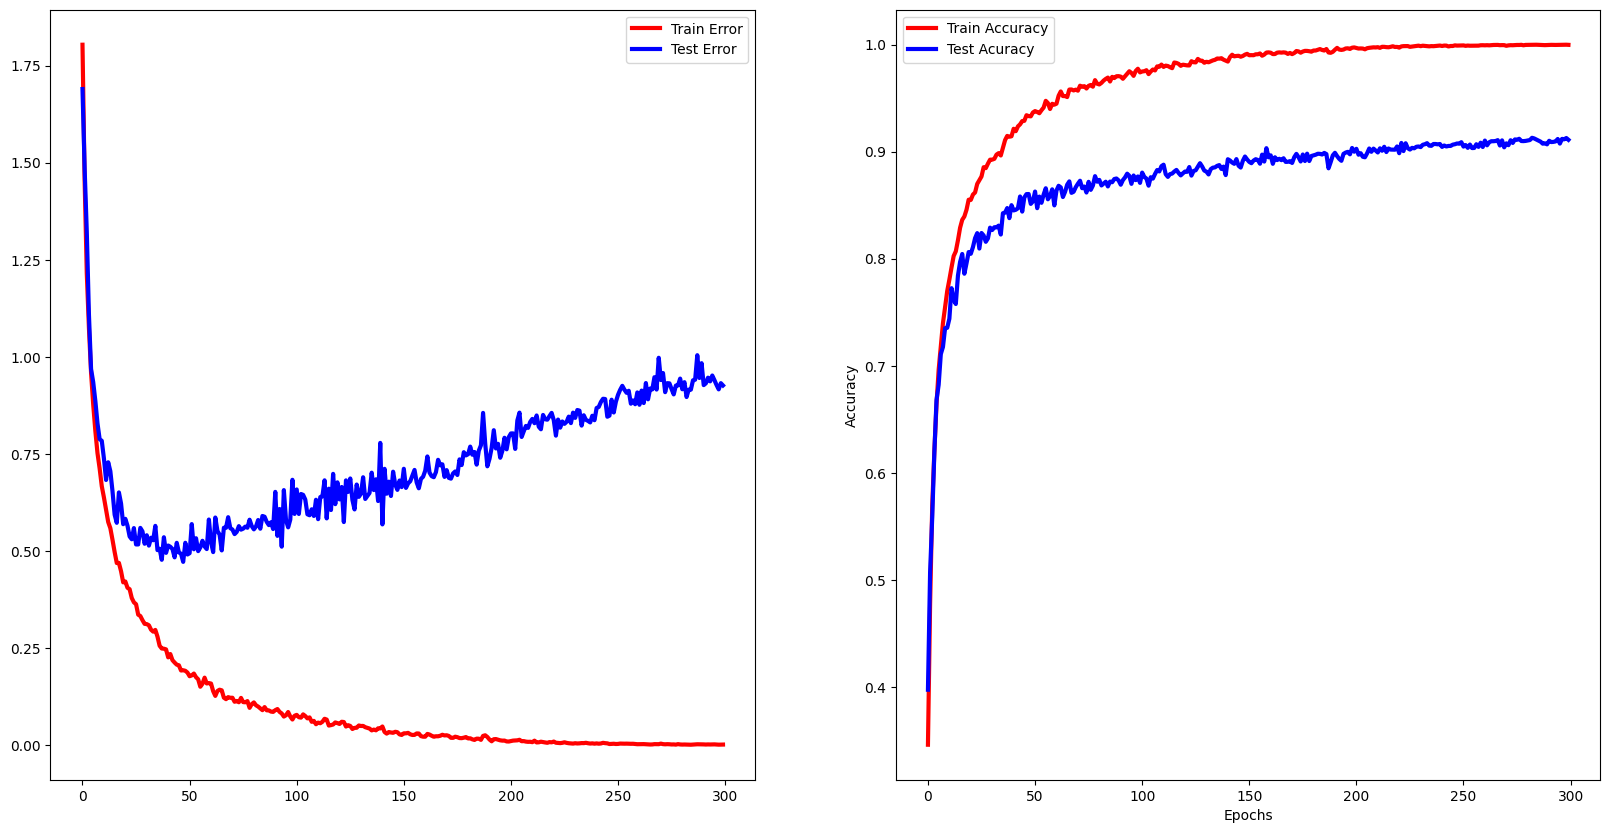

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.911


In [25]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)

torch.onnx.export(model, x, "final_resnet_model.onnx", opset_version = 11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

